# Analysing time series with hidden Markov models <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description

Hidden Markov models (HMM) are a way to model time series as a hidden state machine that emits observations. This notebook shows how to use a HMM to analyse a DEA Waterbodies time series.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

We will use `hmmlearn` to build our HMM, which needs to be separately installed.

In [1]:
%%bash
pip install hmmlearn

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Load packages


In [2]:
%matplotlib inline

import multiprocessing
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from hmmlearn import hmm
import scipy.special
import shapely
import geopandas as gpd
import sklearn.decomposition
import sklearn.cluster

import sys

sys.path.insert(1, "../Scripts")
import dea_plotting

### Configuration

Choose which waterbody you want to analyse using a HMM:

In [3]:
geohash = "r3f225n9h"  # Weereewa

Finally, specify the path to the waterbodies CSVs:

In [4]:
waterbody_csv_path = "https://data.dea.ga.gov.au/projects/WaterBodies/timeseries"

### Load DEA Waterbodies data

The DEA Waterbodies time series are stored as CSV files. 
Each waterbody is labelled by a geohash, e.g. Weereewa is `r3f225n9h`. 
They are stored online (on Amazon S3) in a folder named after the first four characters of the geohash, and the filename is the geohash, e.g. Weereewa is at `https://data.dea.ga.gov.au/projects/WaterBodies/timeseries/r3f2/r3f225n9h.csv`. 
Each CSV has three columns: `Observation Date`, `Wet pixel percentage`, `Wet pixel count (n = ?)` where ? is the total number of observations. 
An example is:

    Observation Date,Wet pixel percentage,Wet pixel count (n = 230894)
    1987-05-29T23:14:29Z,,
    1987-07-16T23:15:29Z,,
    1987-09-02T23:16:50Z,,
    1987-09-18T23:17:13Z,19.9,45926
    
First we will read the CSV containing the surface area vs time observations data directly from the URL path using `pandas`.
We will rename the `Observation Date, Wet pixel percentage, Wet pixel count (n = ?)` columns to more consistent and easier to access names:
```
    date, pc_wet, px_wet
 ```
    
We also ensure that the 'date' column is parsed as a `datetime`, and convert the data percentages to decimals:

In [5]:
def load_waterbodies_csv(geohash):
    # Set path to the CSV file
    csv_path = f"{waterbody_csv_path}/{geohash[:4]}/{geohash}.csv"

    # Load the data using `pandas`:
    time_series = pd.read_csv(
        csv_path,
        header=0,
        names=["date", "pc_wet", "px_wet"],
        parse_dates=["date"],
        index_col="date",
    )
    time_series.index = time_series.index.astype("datetime64[ns]")

    # Convert percentages into a float between 0 and 1.
    time_series.pc_wet /= 100

    # Drop null values.
    time_series = time_series[pd.notnull(time_series.px_wet)]
    return time_series

In [6]:
time_series = load_waterbodies_csv(geohash)

## Simulating a time series

Before we analyse any real waterbodies, which probably don't behave like a HMM in reality, we'll try analysing a simulated time series that we know is derived from a HMM. First, build the HMM: We'll assume there are 3 hidden states and they emit weakly positive, strongly positive, or negative values. There will be a 90% chance of staying in the same state each time and a higher chance of moving into a neighbouring state than a non-neighbouring state.

In [7]:
n_states = 3
means = np.array([-2, 0.5, 1.5])
stdevs = np.array([0.5, 0.5, 1])
start_probability = np.array([1, 1, 1]) / 3
transition_probability = np.array([
    [0.9, 0.075, 0.025],
    [0.05, 0.9, 0.5],
    [0.025, 0.075, 0.9],
])

In [8]:
def emit(means, stdevs, current_state):
    mean = means[current_state]
    stdev = stdevs[current_state]
    return np.random.normal(loc=mean, scale=stdev)

def simulate_hmm(n_states, means, stdevs, start_probability, transition_probability, n_steps):
    start_state = np.random.multinomial(1, start_probability).argmax()
    current_state = start_state
    emissions = []
    states = []
    for i in range(n_steps):
        states.append(current_state)
        emissions.append(emit(means, stdevs, current_state))
        next_probs = transition_probability[current_state]
        current_state = np.random.multinomial(1, next_probs).argmax()
    return np.array(emissions), np.array(states)

In [9]:
hmm_series, hmm_states = simulate_hmm(n_states, means, stdevs, start_probability, transition_probability, 1000)

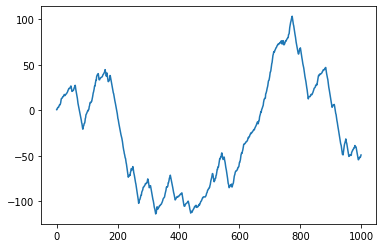

In [10]:
plt.plot(np.cumsum(hmm_series))

## Fitting a HMM to the simulated series

Build an HMM using `hmmlearn`. We have an advantage with the simulation in that we _know_ what parameters went in. There are three components and we do have a Gaussian mixture model for emissions. So, we'll use a matching 3-component Gaussian HMM to try and fit the simulation:

In [11]:
h = hmm.GaussianHMM(n_components=3, algorithm='map')

In [12]:
h.fit(hmm_series.reshape(-1, 1), (1000,))

GaussianHMM(algorithm='map', n_components=3)

We can then compare the transition matrix, means, and standard deviations to our simulation:

In [13]:
print('found transitions:', h.transmat_.round(3), sep='\n')
print('actual transitions:', transition_probability, sep='\n')
print()
print('found means:', h.means_.round(3).ravel(), sep='\n')
print('actual means:', means, sep='\n')
print()
print('found stdevs:', h.covars_.round(3).ravel(), sep='\n')
print('actual stdevs:', stdevs, sep='\n')
print()

found transitions:
[[0.668 0.288 0.045]
 [0.208 0.754 0.037]
 [0.02  0.068 0.913]]
actual transitions:
[[0.9   0.075 0.025]
 [0.05  0.9   0.5  ]
 [0.025 0.075 0.9  ]]

found means:
[ 1.384  0.466 -1.969]
actual means:
[-2.   0.5  1.5]

found stdevs:
[0.969 0.213 0.241]
actual stdevs:
[0.5 0.5 1. ]



Note that the order may be different between the states. Besides the order, though, these states are pretty close to correct. Let's sample from this time series.

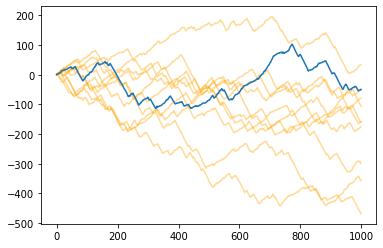

In [14]:
for i in range(10):
    plt.plot(np.cumsum(h.sample(1000)[0].ravel()), c='orange', alpha=0.4)
plt.plot(np.cumsum(hmm_series))

These all look pretty similar! We've captured the behaviour of this time series.

## Transform the time series

On the simulated time series, we used `np.cumsum` to add up changes over time. In a waterbodies context, this is like adding up inflows and outflows to get the total amount of water. The catch is that the amount of water in a waterbody is bounded: there's a maximum and minimum possible water level. We could smoothly constrain the simulation to have bounds too by imposing something like a sigmoid on it:

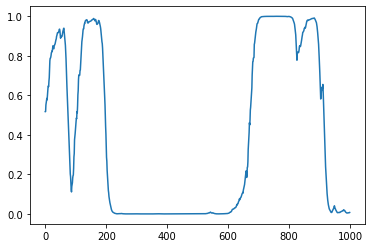

In [15]:
plt.plot(scipy.special.expit(np.cumsum(hmm_series) / 10))

This gives a result that looks a lot like a real waterbody.

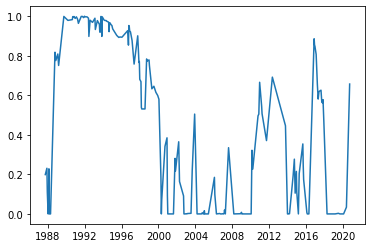

In [16]:
plt.plot(time_series.pc_wet)

If we _invert_ this transformation, then we can get an "unbounded" time series for the real observations. The inverse isn't defined at zero or one, so we need to assume that the waterbody always has at least a little bit of water in it and is never quite full.

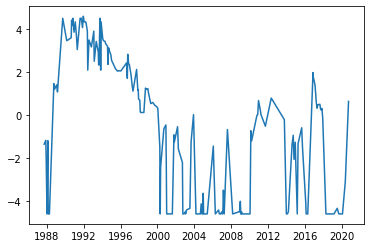

In [17]:
delta = 1e-2
plt.plot(scipy.special.logit(delta + (1 - 2 * delta) * time_series.pc_wet))

To get back to the original inflows and outflows, we can "difference" the time series. It turns out to be way easier to model inflows and outflows than a general time series, so this is a good idea anyway.

In [18]:
transformed_time_series = np.diff(scipy.special.logit(delta + (1 - 2 * delta) * time_series.pc_wet))

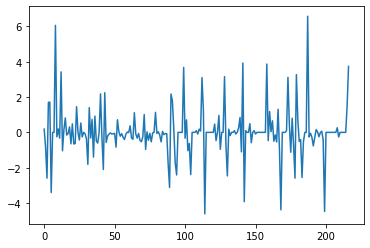

In [19]:
plt.plot(transformed_time_series)

## Fit the HMM

Just as we did for the simulated time series, we can now build and fit a HMM.

In [20]:
h = hmm.GaussianHMM(n_components=3, algorithm='map')

In [21]:
h.fit(transformed_time_series.reshape(-1, 1))

GaussianHMM(algorithm='map', n_components=3)

We can sample from it if we want, too:

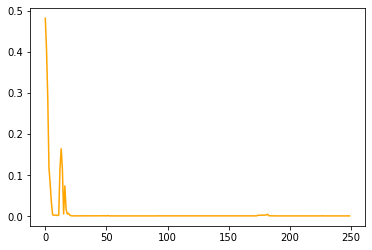

In [22]:
plt.plot(scipy.special.expit(np.cumsum(h.sample(250)[0].ravel())), c='orange', alpha=1)

We can also examine the means and standard deviations of the emissions:

In [23]:
h.means_

array([[-0.0727831 ],
       [ 1.4449475 ],
       [-0.89811372]])

In [24]:
h.covars_

array([[[0.04151275]],

       [[3.86760001]],

       [[2.69595109]]])

We have a positive, negative, and weakly negative state. The positive state is 1, corresponding to periods of inflow, and the negative state is 2, corresponding to periods of outflow.

The hidden states of the HMM can be found with the Viterbi algorithm, also implemented in `hmmlearn`:

In [25]:
_, seq = h.decode(transformed_time_series.reshape(-1, 1), algorithm='viterbi', )

In [26]:
seq

array([0, 1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

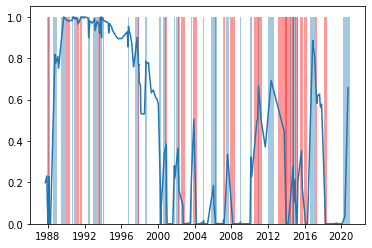

In [27]:
plt.bar(time_series.index[1:], seq == 1, width=time_series.index[1:] - time_series.index[:-1], alpha=0.4)
plt.bar(time_series.index[1:], seq == 2, width=time_series.index[1:] - time_series.index[:-1], alpha=0.4, color='red')
plt.plot(time_series.index, time_series.pc_wet)

## Extension: Using HMM to represent waterbodies

Let's try out using the HMM parameters to represent waterbodies by clustering them in a region. First, we'll select the region:

In [28]:
southwest = (-30.22260, 147.00161)
northeast = (-29.65049, 147.90825)

ylim, xlim = zip(southwest, northeast)

In [29]:
dea_plotting.display_map(xlim, ylim)

Select all waterbodies in this area. We will do this by querying a GeoJSON file that contains all waterbody centroids from DEA Waterbodies.

In [30]:
with zipfile.ZipFile('../Supplementary_data/Waterbodies/DEAWaterbodies_centroids.geojson.zip', 'r') as zip_:
    zip_.extract('DEAWaterbodies_centroids.geojson')

In [31]:
centroids = gpd.read_file('DEAWaterbodies_centroids.geojson').to_crs('EPSG:4326')

In [32]:
in_x = (centroids.geometry.x <= xlim[1]) & (centroids.geometry.x >= xlim[0])
in_y = (centroids.geometry.y <= ylim[1]) & (centroids.geometry.y >= ylim[0])
sel = in_x & in_y

In [33]:
geohashes = list(centroids[sel].geohash)

In [34]:
with multiprocessing.pool.Pool(processes=8) as pool:
    map_ = pool.imap(load_waterbodies_csv, geohashes)
    waterbody_time_series = []
    for gh in tqdm(map_, total=len(geohashes)):
        waterbody_time_series.append(gh)

In [35]:
wbs = pd.concat([w.pc_wet for w in waterbody_time_series], axis=1)
wbs.columns = geohashes
wbs = wbs.interpolate(how='time').bfill()

Transform the waterbodies by resampling them and taking the gradient.

In [36]:
transformed_pc_wet = np.gradient(wbs.resample('1W').mean().interpolate(), axis=0)

Fit a HMM to each time series.

In [57]:
hmms = []
for i in tqdm(transformed_pc_wet.T):
    h2 = hmm.GaussianHMM(n_components=3)
    h2.fit(i.reshape(-1, 1))
    hmms.append(h2)

Pull out the parameters to represent each waterbody.

In [38]:
# Reorder states in order of means.
means = []
covars = []
tms = []
for h in hmms:
    means_ = h.means_.ravel()
    covars_ = h.covars_.ravel()
    tm = h.transmat_
    ordering = means_.argsort()
    tm = tm[np.ix_(ordering, ordering)]
    means.append(means_[ordering])
    covars.append(covars_[ordering])
    tms.append(tm.ravel())

In [39]:
tms = np.array(tms)
means = np.array(means)
covars = np.array(covars)

In [40]:
features = np.concatenate([means, covars, tms], axis=1)

Visualise the feature space using principal component analysis (PCA):

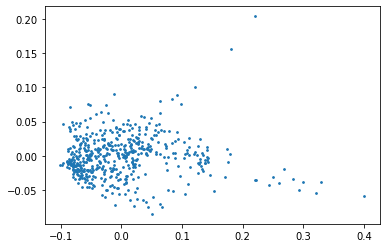

In [41]:
pca_f = sklearn.decomposition.PCA(n_components=2).fit_transform(features)
plt.scatter(*pca_f.T, s=3)

Now try to cluster using K-means.

In [42]:
clusterer = sklearn.cluster.KMeans(n_clusters=2)

In [43]:
clusters = clusterer.fit_predict(features)

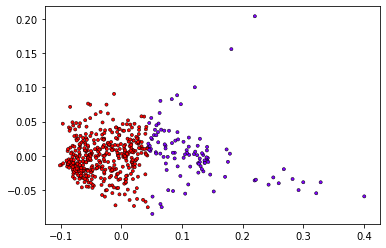

In [44]:
plt.scatter(*pca_f.T, s=10, c=clusters, cmap='rainbow', edgecolor='k', linewidth=0.5)

Examine these clusters in DEA Maps by exporting them as GeoJSON.

In [45]:
for i in range(2):
    centroids.set_index('geohash').loc[np.array(geohashes)[clusters == i]].to_file(f'cluster_{i}.geojson', driver='GeoJSON')

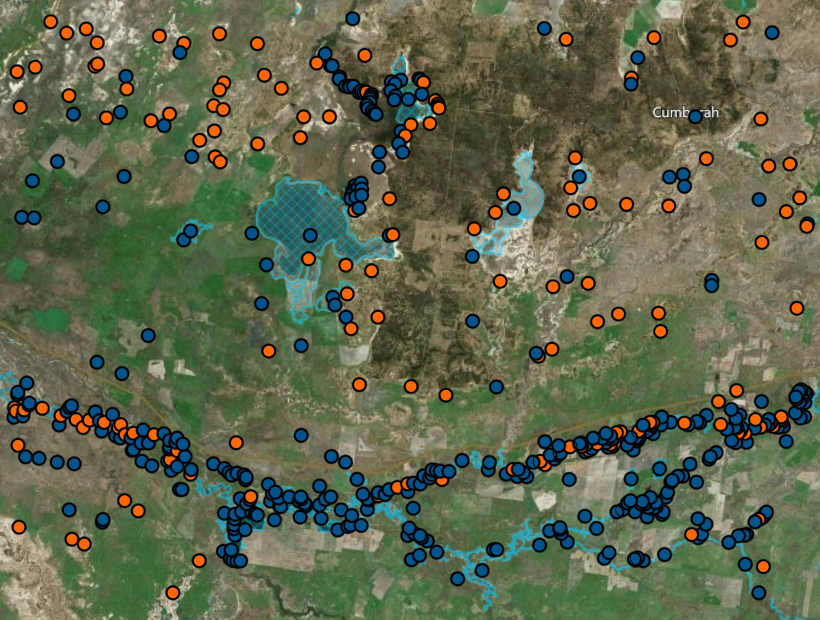

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)